# Convert sensor data into heart rate

Many wearable device can measure heart rate, the heart rate sensor is known as photoplethysmography. 

This technology is based on a very simple fact: Blood is red because it reflects red light and absorbs green light. The heart rate sensor uses green LED lights paired with light‑sensitive photodiodes to detect the amount of blood flowing through your wrist at any given moment. When your heart beats, the blood flow in your wrist — and the green light absorption — is greater. Between beats, it’s less. By flashing its LED lights hundreds of times per second, the wearable device can then calculate the number of times the heart beats each minute — your heart rate.
 
The problem of photoplethysmography is that the photodiodes signal contain a lot of noise, the objective of this challenge is to extract the peak and trough from the noisy signal.

In [1]:
# 1 - Plot peak and trough of the wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

data = pd.read_csv('heartrate_data.csv')

In [2]:
# User define functions
# Moving average
def moving_ave(ts, n):
    # ts is the time series
    # n is the number of points before and after
    mv = np.empty(ts.size)*np.nan
    for i in range(0,n):
        mv[i] = np.nanmean(ts[0:i+n])
    for i in range(n+1,ts.size):
        mv[i] = np.nanmean(ts[i-n:i+n])
    return mv

def find_change(ts,cond):
    tsg = np.gradient(ts)
    # cond: 'change', 'peak', 'trough', 'Lchange'
    change = np.empty(tsg.size)*np.nan
    peak = np.empty(tsg.size)*np.nan
    trough = np.empty(tsg.size)*np.nan
    for n in range(0,tsg.size-1):
        first = np.sign(tsg[n])
        second = np.sign(tsg[n+1])
        if first != second:
            change[n] = 1
        if first == 1 and second == -1:
            peak[n] = 1            
        if first == -1 and second == 1:            
            trough[n] = 1
        if first == second:
            change[n] = 0
            peak[n] = 0
            trough[n] = 0
        if  first == -1:
            peak[0] = 0
        if  first == 1:
            trough[0] = 0   
    Fchange = np.where(change == 1)[0]
    Fpeak = np.where(peak == 1)[0]
    Ftrough = np.where(trough == 1)[0]    
    if cond == 'change':
        return Fchange
    if cond == 'peak':
        return Fpeak
    if cond == 'trough':
        return Ftrough    

In [3]:
# Define new variables
Vmean = np.nanmean(data['VALUE'])
Vstd = np.nanstd(data['VALUE'])
# Anomaly
data['Anomaly'] = data['VALUE'] - Vmean
# Standardise the data
data['Standardise'] = (data['VALUE'] - Vmean)/Vstd
# Moving average
data['MovingAve'] = moving_ave(data['VALUE'],100)
# Value - Moving average
data['VsubMV'] = data['VALUE'] - data['MovingAve']
# VsumMV moving average1
data['VsubMV_s'] = moving_ave(data['VsubMV'],10)
# VsumMV moving average2
data['VsubMV_ss'] = moving_ave(data['VsubMV_s'],5)
# Gradient
data['Grad'] = np.gradient(data['VsubMV_s'])

# Gradient Change, peak and trough
xchange1 = find_change(data['VsubMV_s'],'change')
ychange1 = data['VsubMV_s'][xchange1]
xpeak1 = find_change(data['VsubMV_s'],'peak')
ypeak1 = data['VsubMV_s'][xpeak1]
xtrough1 = find_change(data['VsubMV_s'],'trough')
ytrough1 = data['VsubMV_s'][xtrough1]

xchange2 = find_change(data['VsubMV_ss'],'change')
ychange2 = data['VsubMV_ss'][xchange2]
xpeak2 = find_change(data['VsubMV_ss'],'peak')
ypeak2 = data['VsubMV_ss'][xpeak2]
xtrough2 = find_change(data['VsubMV_ss'],'trough')
ytrough2 = data['VsubMV_ss'][xtrough2]

In [20]:
# Check out the data
data.head()

,Unnamed: 0,TIMESTAMP,PAYLOAD,VALUE,Anomaly,Standardise,MovingAve,VsubMV,VsubMV_s,VsubMV_ss,Grad
0,843351,2016-04-15 19:24:56.50,"0B,3E,4E,00,1E,81,FF,F6,00,1A,FF,C3",-728525,14640.108637,0.411096,-728759.130000,234.130000,72.362862,40.242228,-15.223070
1,843352,2016-04-15 19:24:56.51,"0B,3F,31,00,1E,D6,FF,F6,00,1A,FF,C3",-728667,14498.108637,0.407109,-728737.702970,70.702970,57.139792,28.201609,-16.707825
2,843353,2016-04-15 19:24:56.52,"0B,3E,B7,00,1F,28,FF,F6,00,1A,FF,C2",-728463,14702.108637,0.412837,-728717.980392,254.980392,38.947212,17.266087,-13.443161
3,843354,2016-04-15 19:24:56.53,"0B,3F,75,00,1E,D2,FF,F6,00,1A,FF,C2",-728739,14426.108637,0.405087,-728699.262136,-39.737864,30.253470,5.810024,-18.219703
4,843355,2016-04-15 19:24:56.54,"0B,3E,AD,00,1F,17,FF,F6,00,1A,FF,C3",-728470,14695.108637,0.412641,-728680.778846,210.778846,2.507805,-4.438025,-31.127479


((29000, 29999), (-808383.0, -793880.0))

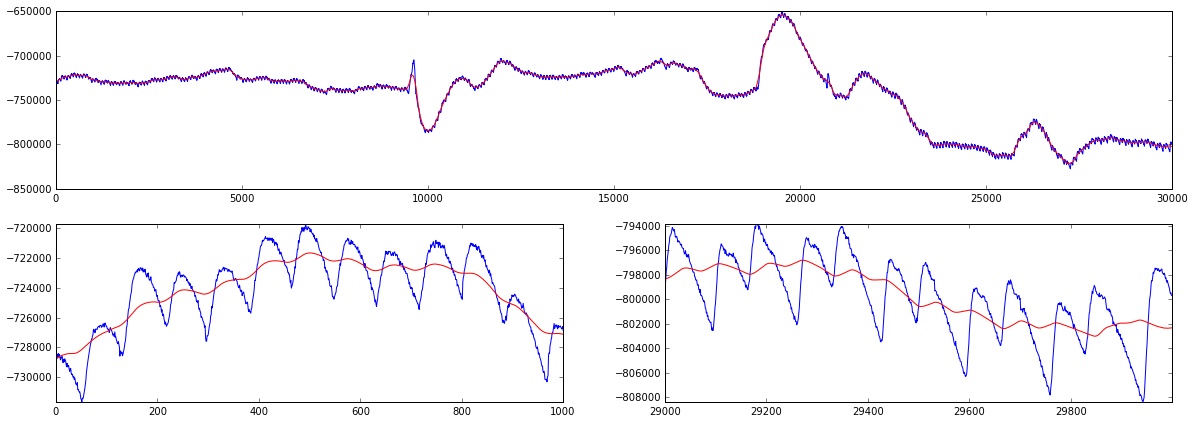

In [21]:
# Create a line that go through between the peak and trough of the data
fig, ax = plt.subplots(figsize=(20, 7))
ts1 = data['VALUE']
ts2 = data['MovingAve']

plt.subplot(2,1,1)
plt.plot(ts1, color = 'blue')
plt.plot(ts2, color = 'red')

plt.subplot(2,2,3)
plt.plot(ts1, color = 'blue')
plt.plot(ts2, color = 'red')

xrange = [0,1000]
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange),

plt.subplot(2,2,4)
plt.plot(ts1, color = 'blue')
plt.plot(ts2, color = 'red')
xrange = [29000,ts1.size]
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

((29000, 29999), (-6628.420382165583, 4782.766666666721))

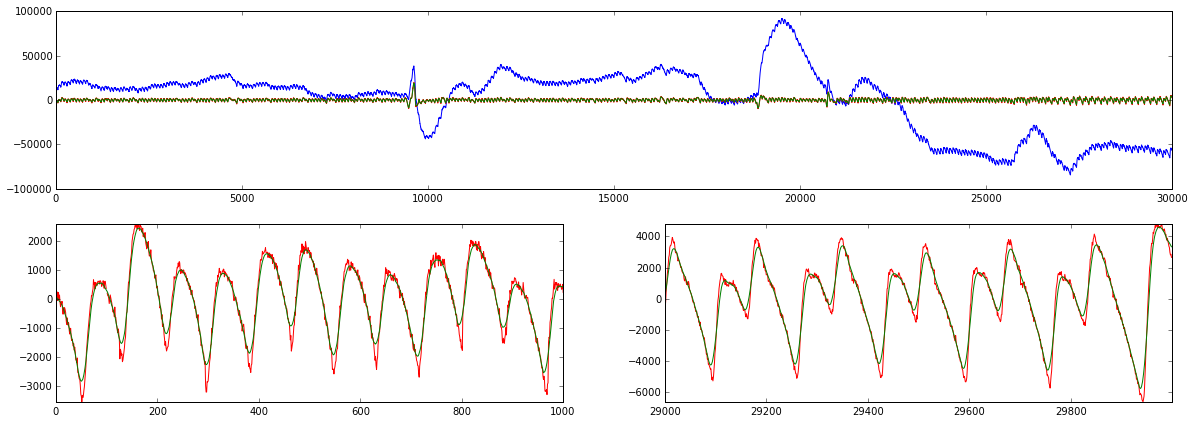

In [22]:
# Standardisation and smooth the line
fig, ax = plt.subplots(figsize=(20, 7))
ts1 = data['Anomaly']
ts2 = data['VsubMV']
ts3 = data['VsubMV_s']

plt.subplot(2,1,1)
plt.plot(ts1,color = 'blue'), plt.plot(ts2,color = 'red'), plt.plot(ts3,color = 'green')

plt.subplot(2,2,3)
plt.plot(ts1,color = 'blue'), plt.plot(ts2,color = 'red'), plt.plot(ts3,color = 'green')

xrange = [0,1000]
yrange = ts2[xrange[0]:xrange[1]].min(), ts2[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

plt.subplot(2,2,4)
xrange = [29000,ts1.size]
plt.plot(ts1,color = 'blue'), plt.plot(ts2,color = 'red'), plt.plot(ts3,color = 'green')
yrange = ts2[xrange[0]:xrange[1]].min(), ts2[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

((29000, 29999), (-6628.420382165583, 4782.766666666721))

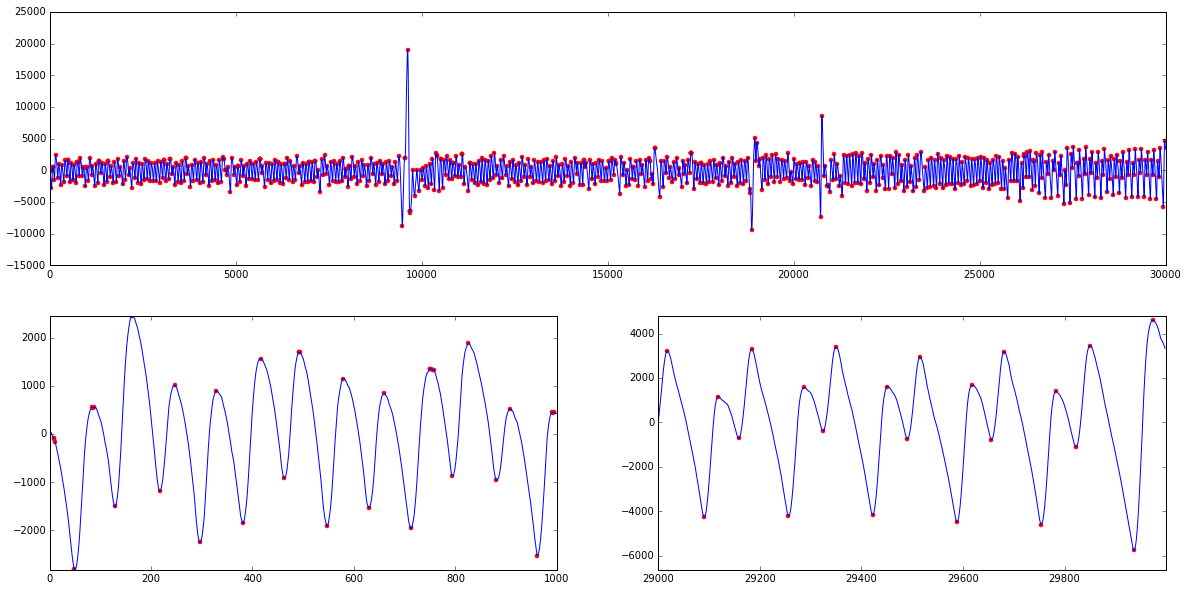

In [23]:
# plot every changing point
fig, ax = plt.subplots(figsize=(20, 10))
ts1 = data['VsubMV_s']

plt.subplot(2,1,1)
plt.plot(ts1,color = 'blue')
plt.scatter(xchange1,ychange1,marker='.',color='r', s=50)
plt.xlim([0,ts1.size])

plt.subplot(2,2,3)
xrange = [0,1000]
plt.plot(ts1,color = 'blue')
plt.scatter(xchange1,ychange1,marker='.',color='r', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

plt.subplot(2,2,4)
xrange = [29000,ts1.size]
plt.plot(ts1,color = 'blue')
plt.scatter(xchange1,ychange1,marker='.',color='r', s=50)
yrange = ts2[xrange[0]:xrange[1]].min(), ts2[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

((29000, 29999), (-5770.220553054777, 4599.695472864364))

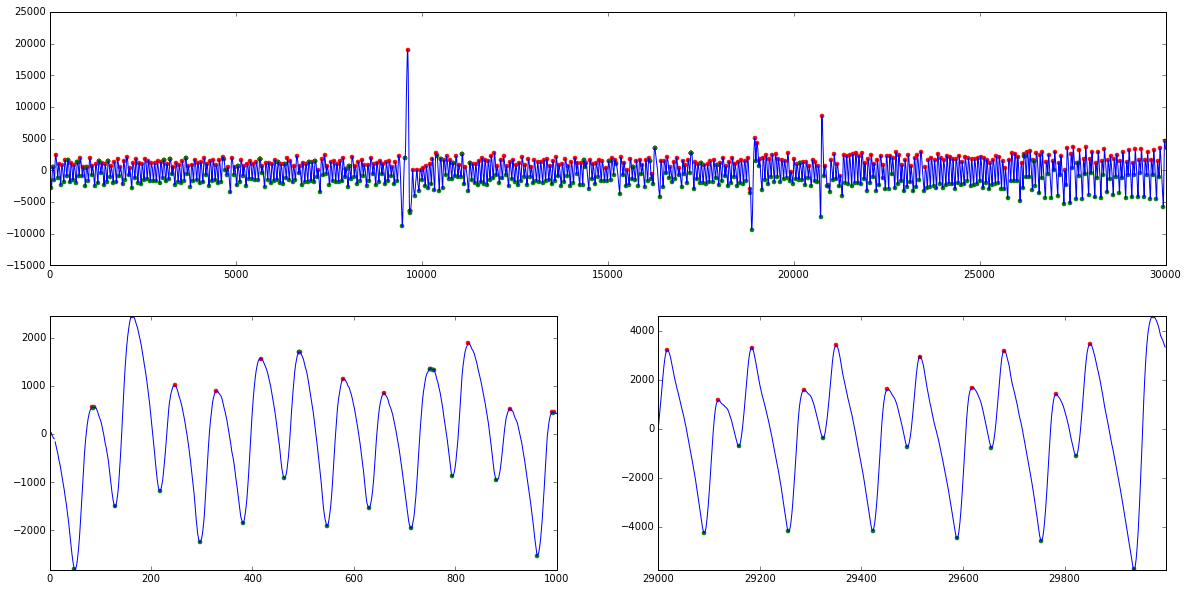

In [24]:
# plot peak and trough 1
fig, ax = plt.subplots(figsize=(20, 10))
ts1 = data['VsubMV_s']

plt.subplot(2,1,1)
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak1,ypeak1,marker='.',color='r', s=50)
plt.scatter(xtrough1,ytrough1,marker='.',color='g', s=50)
plt.xlim([0,ts1.size])

plt.subplot(2,2,3)
xrange = [0,1000]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak1,ypeak1,marker='.',color='r', s=50)
plt.scatter(xtrough1,ytrough1,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

plt.subplot(2,2,4)
xrange = [29000,ts1.size]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak1,ypeak1,marker='.',color='r', s=50)
plt.scatter(xtrough1,ytrough1,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

((29000, 29999), (-5586.791623667898, 4560.178697515703))

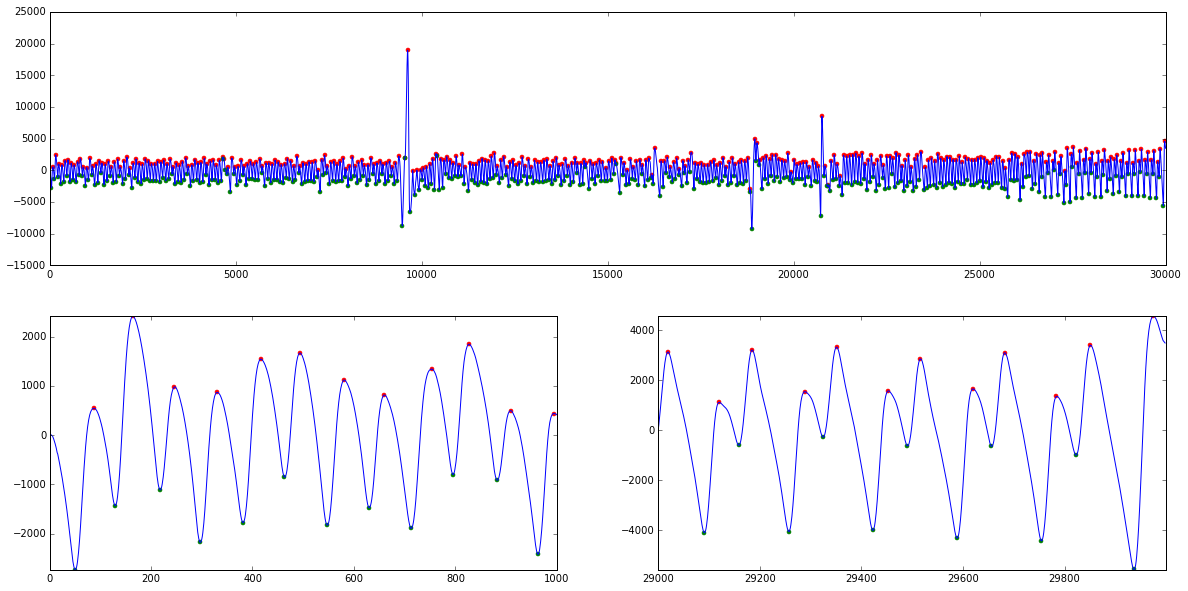

In [25]:
# plot peak and trough 1
fig, ax = plt.subplots(figsize=(20, 10))
ts1 = data['VsubMV_ss']

plt.subplot(2,1,1)
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak2,ypeak2,marker='.',color='r', s=50)
plt.scatter(xtrough2,ytrough2,marker='.',color='g', s=50)
plt.xlim([0,ts1.size])

plt.subplot(2,2,3)
xrange = [0,1000]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak2,ypeak2,marker='.',color='r', s=50)
plt.scatter(xtrough2,ytrough2,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

plt.subplot(2,2,4)
xrange = [29000,ts1.size]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak2,ypeak2,marker='.',color='r', s=50)
plt.scatter(xtrough2,ytrough2,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)

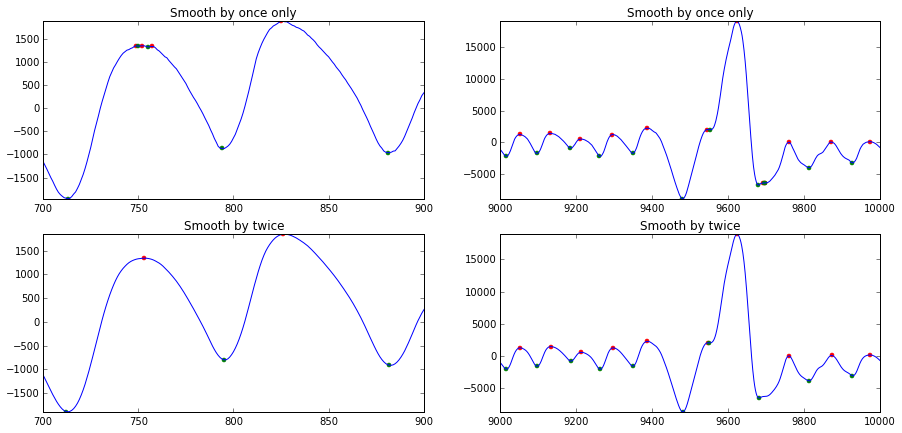

In [26]:
# Compare result after smooth 1 time and 2 times

fig, ax = plt.subplots(figsize=(15, 7))
plt.subplot(2,2,1)
ts1 = data['VsubMV_s']
xrange = [700,900]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak1,ypeak1,marker='.',color='r', s=50)
plt.scatter(xtrough1,ytrough1,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)
plt.title('Smooth by once only')

plt.subplot(2,2,2)
ts1 = data['VsubMV_s']
xrange = [9000,10000]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak1,ypeak1,marker='.',color='r', s=50)
plt.scatter(xtrough1,ytrough1,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)
plt.title('Smooth by once only')

plt.subplot(2,2,3)
ts1 = data['VsubMV_ss']
xrange = [700,900]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak2,ypeak2,marker='.',color='r', s=50)
plt.scatter(xtrough2,ytrough2,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)
plt.title('Smooth by twice')

plt.subplot(2,2,4)
ts1 = data['VsubMV_ss']
xrange = [9000,10000]
plt.plot(ts1,color = 'blue')
plt.scatter(xpeak2,ypeak2,marker='.',color='r', s=50)
plt.scatter(xtrough2,ytrough2,marker='.',color='g', s=50)
yrange = ts1[xrange[0]:xrange[1]].min(), ts1[xrange[0]:xrange[1]].max()
plt.xlim(xrange), plt.ylim(yrange)
plt.title('Smooth by twice')